# Parameter estimation using ordinal data

This Notebook eplains the use of ordinal data for parameter estimation, as described in [Schmiester et al. (2019)](https://www.biorxiv.org/content/10.1101/848648v1.abstract). An example model is provided in `pypesto/doc/example/example_ordinal`

## Import model from the petab_problem

In [32]:
import logging

import amici
import numpy as np
import petab

import pypesto
import pypesto.logging
import pypesto.optimize as optimize
import pypesto.petab
from pypesto.hierarchical.optimal_scaling import OptimalScalingInnerSolver

To specify usage of ordinal data, only `ordinal=True` has to be passed to the constructor of the `PetabImporter`:

In [33]:
petab_folder = './example_ordinal/'
yaml_file = 'example_ordinal.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

# To allow for optimization with ordinal measurements, set ordinal=True, when creating the importer
importer = pypesto.petab.PetabImporter(petab_problem, ordinal=True)

## Construct the objective and pypesto problem

Different options can be used for the optimal scaling approach:
- method: `standard` / `reduced`
- reparameterized: `True` / `False`
- intervalConstraints: `max` / `max-min`
- minGap: Any float value

It is recommended to use the reduced method with reparameterization as it is the most efficient and robust choice.

When no options are provided, the default is the reduced and reparameterized formulation with max as interval constraint and `minGap=1e-10`.

Now when we construct the `objective`, it will construct all objects of the optimal scaling inner optimization:
- `OptimalScalingInnerSolver`
- `OptimalScalingAmiciCalculator`
- `OptimalScalingProblem`

Specifically, the `OptimalScalingInnerSolver` will be constructed with default settings.  

In [34]:
objective = importer.create_objective()

To give non-default options to the `OptimalScalingInnerSolver` and `OptimalScalingProblem`, one can pass them as arguments when constructing the `objective`:

In [35]:
objective = importer.create_objective(
    inner_problem_method='reduced',
    inner_solver_options={
        "method": 'reduced',
        "reparameterized": True,
        "intervalConstraints": "max",
        "minGap": 0.1,
    },
)

Now let's construct the pyPESTO problem and optimizer. We're going to use a gradint-based optimizer for a faster optimization, but gradient-free optimizers can be used in the same way:

In [36]:
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

optimizer = optimize.ScipyOptimizer(
    method="L-BFGS-B",
    options={"disp": None, "ftol": 2.220446049250313e-09, "gtol": 1e-5},
)
n_starts = 10
np.random.seed(n_starts)

## Run optimization using optimal scaling approach

### Run optimization using the reduced and reparameterized approach

If we want to change options of the `OptimalScalingInnerSolver` a new instance of it with new options can be passed to `problem.objective.calculator`:

In [37]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(
    options={
        'method': 'reduced',
        'reparameterized': True,
        'intervalConstraints': 'max',
        'minGap': 1e-10,
    }
)

res_reduced_reparameterized = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


### Run optimization using the reduced non-reparameterized approach

In [38]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(
    options={
        'method': 'reduced',
        'reparameterized': False,
        'intervalConstraints': 'max',
        'minGap': 1e-10,
    }
)

res_reduced = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


### Run optimization using the standard approach

In [39]:
np.random.seed(n_starts)
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(
    options={
        'method': 'standard',
        'reparameterized': False,
        'intervalConstraints': 'max',
        'minGap': 1e-10,
    }
)

res_standard = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


### Compare results

Reduced formulation leads to improved computation times

In [40]:
time_standard = res_standard.optimize_result.get_for_key('time')
print(f"Mean computation time for standard approach: {np.mean(time_standard)}")

time_reduced = res_reduced.optimize_result.get_for_key('time')
print(f"Mean computation time for reduced approach: {np.mean(time_reduced)}")

time_reduced_reparameterized = (
    res_reduced_reparameterized.optimize_result.get_for_key('time')
)
print(
    f"Mean computation time for reduced reparameterized approach: {np.mean(time_reduced_reparameterized)}"
)

Mean computation time for standard approach: 0.885933804512024
Mean computation time for reduced approach: 0.8116438627243042
Mean computation time for reduced reparameterized approach: 0.8603142976760865


All approaches yield the same objective function values

<AxesSubplot: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=9.994e-01)'>

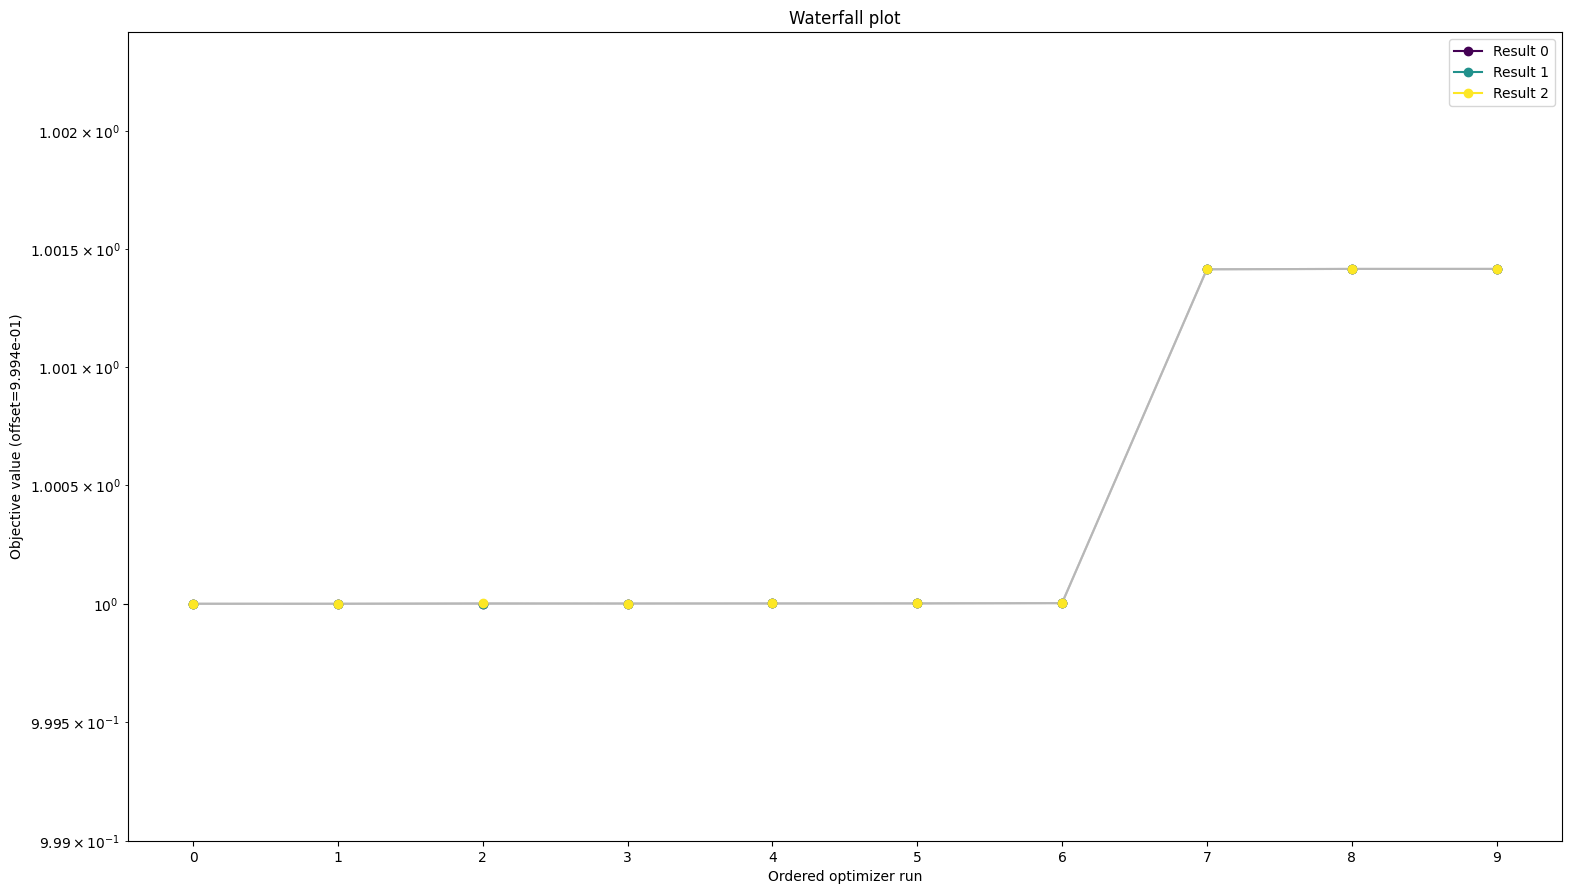

In [41]:
from pypesto.visualize import waterfall

waterfall(
    [res_standard, res_reduced, res_reduced_reparameterized], order_by_id=True
)

To be sure the funtion values are the same we can look at them directly as well:

In [24]:
for start_id in range(10):
    print(
        [
            [
                res.fval
                for res in result.optimize_result.as_list()
                if res.id == str(start_id)
            ]
            for result in [
                res_standard,
                res_reduced,
                res_reduced_reparameterized,
            ]
        ]
    )

[[0.0005735456577138072], [0.0005735455461899655], [0.0005735459232667281]]
[[0.0005735454718572653], [0.00057354550928992], [0.0005735455965197873]]
[[0.000573545619330834], [0.0005735454545587091], [0.00057354549654735]]
[[0.0019888875998486026], [0.0019888875998486147], [0.0019888875998501743]]
[[0.0005735454942711187], [0.0005735454046923066], [0.0005735454092041721]]
[[0.0005735463987237045], [0.0005735454654377569], [0.0005735456308596415]]
[[0.0005735455019825164], [0.0005735454874248229], [0.0005735454610488298]]
[[0.0005735458513320824], [0.0005735454537586973], [0.0005735454581835225]]
[[0.000573545866531529], [0.0005735457953069544], [0.0005735457935496884]]
[[0.0005735459471489623], [0.0005735455991299835], [0.0005735455973437948]]
